<a href="https://colab.research.google.com/github/danieljai/CIND820-AndyLee/blob/main/AndyLee_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 3: Preload setup

Basic setup so results can utilize the full width of the screen.

In [1]:
%config IPCompleter.greedy=True
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

# Step 4: Import Dataset

The hydrated file is stored in a Google Drive, and using the follow code will mount Google Drive onto Colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/My Drive/__CIND 820 - Data Analytics Project/3-data/Book1-fastsave.csv")

# Step 5. Data Cleaning and Manipulation

## Preview data after cleaning and manipulation

Original Tweet dataframe datatypes

In [4]:
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object
df.dtypes

coordinates                    object
created_at                     object
hashtags                       object
media                          object
urls                           object
favorite_count                  int64
id                              int64
in_reply_to_screen_name        object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
lang                           object
place                          object
possibly_sensitive             object
retweet_count                   int64
retweet_id                    float64
retweet_screen_name            object
source                         object
text                           object
tweet_url                      object
user_created_at                object
user_screen_name               object
user_default_profile_image       bool
user_description               object
user_favourites_count           int64
user_followers_count            int64
user_friends_count              int64
user_listed_

## Readjust attribute datatype

For `retweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert `null` values to 0
- Convert attribute as int64

In [5]:
df.retweet_id = df[df['retweet_id'].notnull()].retweet_id.astype('int64') 

In [6]:
df.retweet_id = df.retweet_id.fillna(0).astype('int64')
df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')

## Misc. cleaning up to reduce noise when conducting sentimental analysis
1. remove \n
2. remove URL
3. remove user referrals
4. remove hashtags

In [7]:
df['modified_text'] = df.text.str.replace(r'\n', '')
df['modified_text'] = df.modified_text.str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '')
df['modified_text'] = df.modified_text.str.replace(r'\B@\w+', '')
df['modified_text'] = df.modified_text.str.replace(r'\B#\w+', '')

## Splitting Dataframes (originals and retweets)

The collection includes both original tweets and retweets. Since retweets mirrors the original tweet by someone else other than the author, we don't need to run sentimental analysis on the retweet as it would have been run on the original tweet, therefore we can split original tweets and retweets into two dataframes to avoid wasting resources.


- Original tweets: `dfOriginals`
- Retweets: `dfRetweets` cons





In [8]:
dfOriginals = df[df.retweet_id == 0]
dfRetweets = df[df.retweet_id != 0]

Two samples of the original tweet dataframe.

In [9]:
dfOriginals.sample(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text
272908,NaN,Tue Mar 31 13:05:10 +0000 2020,NaN,NaN,https://twitter.com/karelynsanity_/status/1244789975054508038,0,1244974015283900417,NaN,0,0,en,NaN,False,0,0,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This won’t do anything for corona but it’ll clear the shit out of your system https://t.co/3EN0eY5d2G,https://twitter.com/frakes_jaryd/status/1244974015283900417,Tue Jan 10 01:16:26 +0000 2017,frakes_jaryd,False,BLM✊,7514,256,383,2,"New Bedford, MA",Frosted Frakes❄️,frakes_jaryd,8174,NaN,NaN,False,This won’t do anything for corona but it’ll clear the shit out of your system
111492,NaN,Tue Mar 31 08:30:00 +0000 2020,NaN,https://twitter.com/RanaSar94401127/status/1244904768901873670/photo/1,NaN,1,1244904768901873670,NaN,0,0,en,NaN,False,0,0,NaN,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",Social mobilization activity about corona virus .Rana Sarfraz SHNS Lodhran https://t.co/0tnLrzJKv0,https://twitter.com/RanaSar94401127/status/1244904768901873670,Sat Feb 20 13:52:09 +0000 2016,RanaSar94401127,False,NaN,59,102,210,0,Pakistan,Rana Sarfraz SH&NS,RanaSar94401127,56,NaN,NaN,False,Social mobilization activity about corona virus .Rana Sarfraz SHNS Lodhran


## Guessing language

Since our sentiment analysis focuses on only English tweets, we will install a `langdetect` library to help filter out tweets that are not English.

In [10]:
#https://pypi.org/project/langdetect/
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0



     |████████████████████████████████| 983kB 8.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=a6c9b60ede18b92ded14e287fd06e04841f551f63c9cf3f5ffa413fdd442f324
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


Function to test whether tweet is English with error handling.

In [11]:
#https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas

def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False

Passing as the `is_en()` as first-class function; returning a boolean value as a attribute `guessed_language`.

In [12]:
dfOriginals['guessed_language'] = dfOriginals.modified_text.apply(is_en)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


By filtering out non-English tweets, we remove noise that can potentially affect our sentimental analysis.

In [13]:
print("There are " + str(len(dfOriginals)) + " tweets, and " + str(sum(dfOriginals.guessed_language)) + " ("+str(round((sum(dfOriginals.guessed_language) / len(dfOriginals)) * 100, 2))+"%) tweets detect as English.")

There are 245389 tweets, and 232816 (94.88%) tweets detect as English.


# Step 6. Sentiment Analysis

To conduct Seitment Analysis, we begin by importing the NLTK library.

In [14]:
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Applying Sentiment Analysis function

We apply the polarity score function and store results on a new attribute `sentimentscore`.



In [15]:
dfOriginals['sentimentscore'] = dfOriginals.modified_text.apply(sid.polarity_scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


A quick sample preview of the text and its sentiment score.

In [16]:
dfOriginals.sample(2)[['modified_text','sentimentscore']]

,modified_text,sentimentscore
546599,We fighting two plagues: corona and k-pop,"{'neg': 0.294, 'neu': 0.706, 'pos': 0.0, 'compound': -0.3612}"
114793,Yep and her Swedish Soapy Actor dad who seems to speak for outside small well rehearsed short speeches - can immerse themselves in irrelevance in their doomsday prepped powered estate on outskirts of,"{'neg': 0.102, 'neu': 0.782, 'pos': 0.116, 'compound': -0.128}"


The `SentimentIntensityAnalyzer()` returns a dictionary of scores negative, neutral, positive, and compound. Compound is the normalization of negative, neutral, and positive values.


How compound is calculated? https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Next, we expand the score, which is currently as dictionary, into their own attributes for better data manipulation--especially the compound attribute.

In [17]:
dfOriginalSScore = pd.json_normalize(dfOriginals.sentimentscore)
dfOriginalSScore['original_index'] = dfOriginals.index
dfOriginalSScore = dfOriginalSScore.set_index('original_index')

Merge the dataframe with sentiment scores and the dataframe with the original tweets together, onto a new dataframe `dfOriginals_Analyzed`.

In [18]:
dfOriginals_Analyzed = dfOriginals.merge(dfOriginalSScore, left_index=True, right_index=True)

Quick preview of modified text and compound on the merged dataframe.

In [19]:
dfOriginals_Analyzed.sample(10)[['modified_text','compound']]

,modified_text,compound
51151,The one positive thing is that Corona virus isn't trending this week 🤷🏽‍♂️ my feed ain't negative so that's cool 🤙🏽,0.8472
714196,"The Pattern of Corona is just check the Chinese movements across the world.Chinese spreaded this Virus deliberately.They went to Airports,Malls,Community Centres,Tourist points everywhere.They sneezed,Coughed and did everything to spread this.",0.0000
278732,Corona virus wants nothing to do with him.,0.0000
269633,lof pak rudy🤩❤️,0.0000
501970,"Cooking in the time of corona: Lap cheong, shredded chicken and 1000yr old egg congee",0.0000
356921,"Y O U R. D E G R E E. I S. J U S T. A. P I E C E. O F P A P E R. , Y O U R. E D U C A T I O N. I S. S E E N. I N. Y O U R. B E H A V I O U R. #Nizamuddin",0.0000
636016,So now Boeing won’t need to swindle a $60 mil bailout from the Feds under the guise of Corona virus bill?,-0.5859
582390,Many experts including the have already admitted its airborne,0.1027
281976,"Establishment bullshit, now corona attacks minorities more!!!Their tool in their tool bag. Carona is racist.",-0.9114
473075,Hospital via .,0.0000


We binning based on compound scores
-1 to -0.1 = negative 
-0.1 to 0.1  = neutral
0.1 to 1 = positive

The threshold chosen is based on the paper "Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm"

Deo, G. S., Mishra, A., Jalaluddin, Z. M., & Mahamuni, C. V. (2020, September). Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm. In 2020 12th International Conference on Computational Intelligence and Communication Networks (CICN) (pp. 221-228). IEEE.

https://www.researchgate.net/profile/Gouri_Deo/publication/342988903_Predictive_Analysis_of_Resource_Usage_Data_in_Academic_Libraries_using_the_VADER_Sentiment_Algorithm/links/5f1085a6a6fdcc3ed70bcf20/Predictive-Analysis-of-Resource-Usage-Data-in-Academic-Libraries-using-the-VADER-Sentiment-Algorithm.pdf



In [20]:
dfOriginals_Analyzed['sentiment_class_relaxed'] = pd.cut(dfOriginals_Analyzed['compound'], bins=[-1, -0.1, 0.1, 1], right=True, labels=['neg', 'neu', 'pos'])
dfOriginals_Analyzed.sentiment_class_relaxed.value_counts()

neg    89051
pos    84039
neu    72299
Name: sentiment_class_relaxed, dtype: int64

# Step 8. Basic Analysis

Observing the correlation between variables.

In [21]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count']].corr()

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count
favorite_count,1.000000,0.908576,0.165683,-0.001108,0.015366
retweet_count,0.908576,1.000000,0.090025,-0.003071,0.015991
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452
compound,-0.001108,-0.003071,0.003693,1.000000,-0.022604
user_statuses_count,0.015366,0.015991,0.116452,-0.022604,1.000000


In [22]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_verified']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count
count,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000
mean,9.52971,2.70475,9251.20519,-0.01655,27468.30799
std,384.21091,122.27732,250678.23602,0.47919,75560.36124
min,0.00000,0.00000,0.00000,-0.99520,1.00000
25%,0.00000,0.00000,64.00000,-0.39760,1156.00000
50%,0.00000,0.00000,331.00000,0.00000,6344.00000
75%,1.00000,0.00000,1307.00000,0.36120,24616.00000
max,108137.00000,35137.00000,62855265.00000,0.99190,4472178.00000


Plot Distribution of sentiment scores

The histogram shows the distribution appears to have some modes, and rather symmetric.

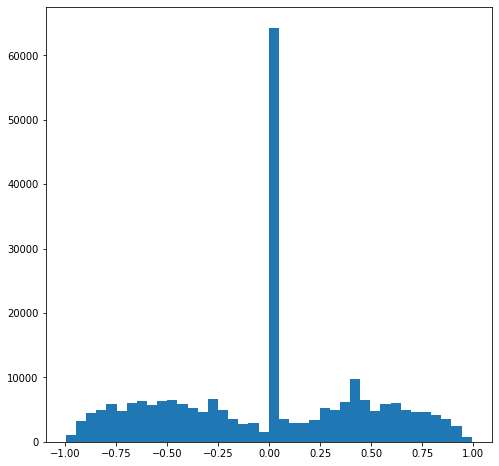

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8)) 
histo_plot = plt.hist(dfOriginals_Analyzed['compound'],bins=40)


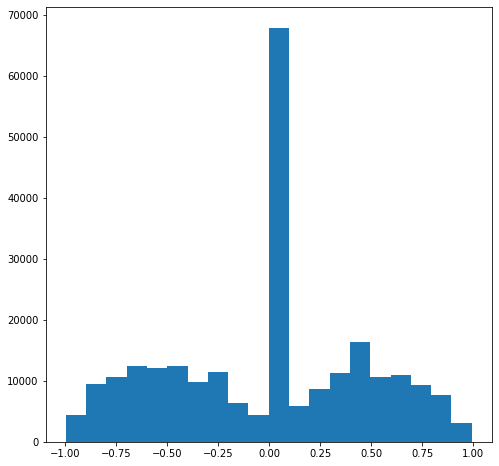

In [24]:
plt.figure(figsize=(8,8)) 
histo_plot2 = plt.hist(dfOriginals_Analyzed['compound'],bins=20)


# Step 9. Build Prediction Model with Linear Regression

## Split Train and Test set

In [25]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound']]

,favorite_count,retweet_count,user_followers_count,compound
3,0,0,54,0.0129
4,0,0,73,0.3400
6,0,0,55,0.4404
7,0,0,79,0.6369
12,0,0,36,0.8885
...,...,...,...,...
799126,0,0,36,-0.9267
799127,1,0,8,0.0000
799128,1,0,5,0.2023
799130,3,0,441,-0.5106


In [131]:
# trying to implement k-fold
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
# https://stackoverflow.com/questions/57398411/next-always-gives-the-same-index-with-a-kfold-generator
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state = 2)

kf_result = kf.split(dfOriginals_Analyzed)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)
train_idx, test_idx = next(kf_result)
print(train_idx, test_idx)


[     0      1      2 ... 245385 245386 245387] [    13     14     16 ... 245369 245377 245388]
[     1      2      3 ... 245386 245387 245388] [     0      9     25 ... 245366 245379 245382]
[     0      1      2 ... 245386 245387 245388] [     4      5     17 ... 245356 245357 245383]
[     0      1      2 ... 245386 245387 245388] [    15     20     26 ... 245352 245363 245368]
[     0      1      2 ... 245384 245387 245388] [     7     33     41 ... 245374 245385 245386]
[     0      1      2 ... 245385 245386 245388] [    10     29     30 ... 245380 245381 245387]
[     0      2      4 ... 245386 245387 245388] [     1      3      6 ... 245360 245371 245376]
[     0      1      3 ... 245386 245387 245388] [     2      8     11 ... 245337 245375 245378]
[     0      1      2 ... 245386 245387 245388] [    19     60     61 ... 245348 245355 245384]
[     0      1      2 ... 245386 245387 245388] [    43     57     85 ... 245354 245370 245373]


In [98]:
from sklearn import preprocessing
from sklearn import linear_model

trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

independent_variables = ['retweet_count','user_followers_count','compound']
# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']

dependent_variables = 'favorite_count'
X_train = (trainSet[independent_variables])
Y_train = trainSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

print("The coefficients of the regression model for features " + ', '.join(independent_variables))
print(reg.coef_)
print("The intercept of the regression model is " + str(reg.intercept_))


The coefficients of the regression model for features retweet_count, user_followers_count, compound
[2.53987154e+00 1.55056871e-04 1.13039598e+00]
The intercept of the regression model is 1.2093078813468576


Run prediction, rounding prediction numbers and setting it as integer.

In [99]:
plot_1_Y = reg.predict(testSet[independent_variables]) # predicted as Y
plot_1_X = testSet[dependent_variables].reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)
df_plot_1

,index,actual,predicted
0,56,0,2
1,75,2,7
2,115,1,2
3,145,0,2
4,149,0,1
...,...,...,...
49073,799003,2,2
49074,799023,0,0
49075,799037,1,1
49076,799056,0,0


# Step 10: Getting Results

Since this is a regression model with continous values, we use Mean Square Error (MSE), Root MSE, and R-square metrics to measure the performance of the model. 

reference: https://stackoverflow.com/questions/49103139/calculating-accuracy-scores-of-predicted-continuous-values

In [100]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from math import sqrt

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
print("Mean Square Error (MSE): " + str(mse))
print("Root MSE: " + str(sqrt(mse)))
print("R-Square: " + str(r2_score(df_plot_1.actual, df_plot_1.predicted)))


Mean Square Error (MSE): 33368.809425811975
Root MSE: 182.67131527914276
R-Square: 0.8733509628767524


Scatterplot to visually observe how well the model's prediction vs actual value.

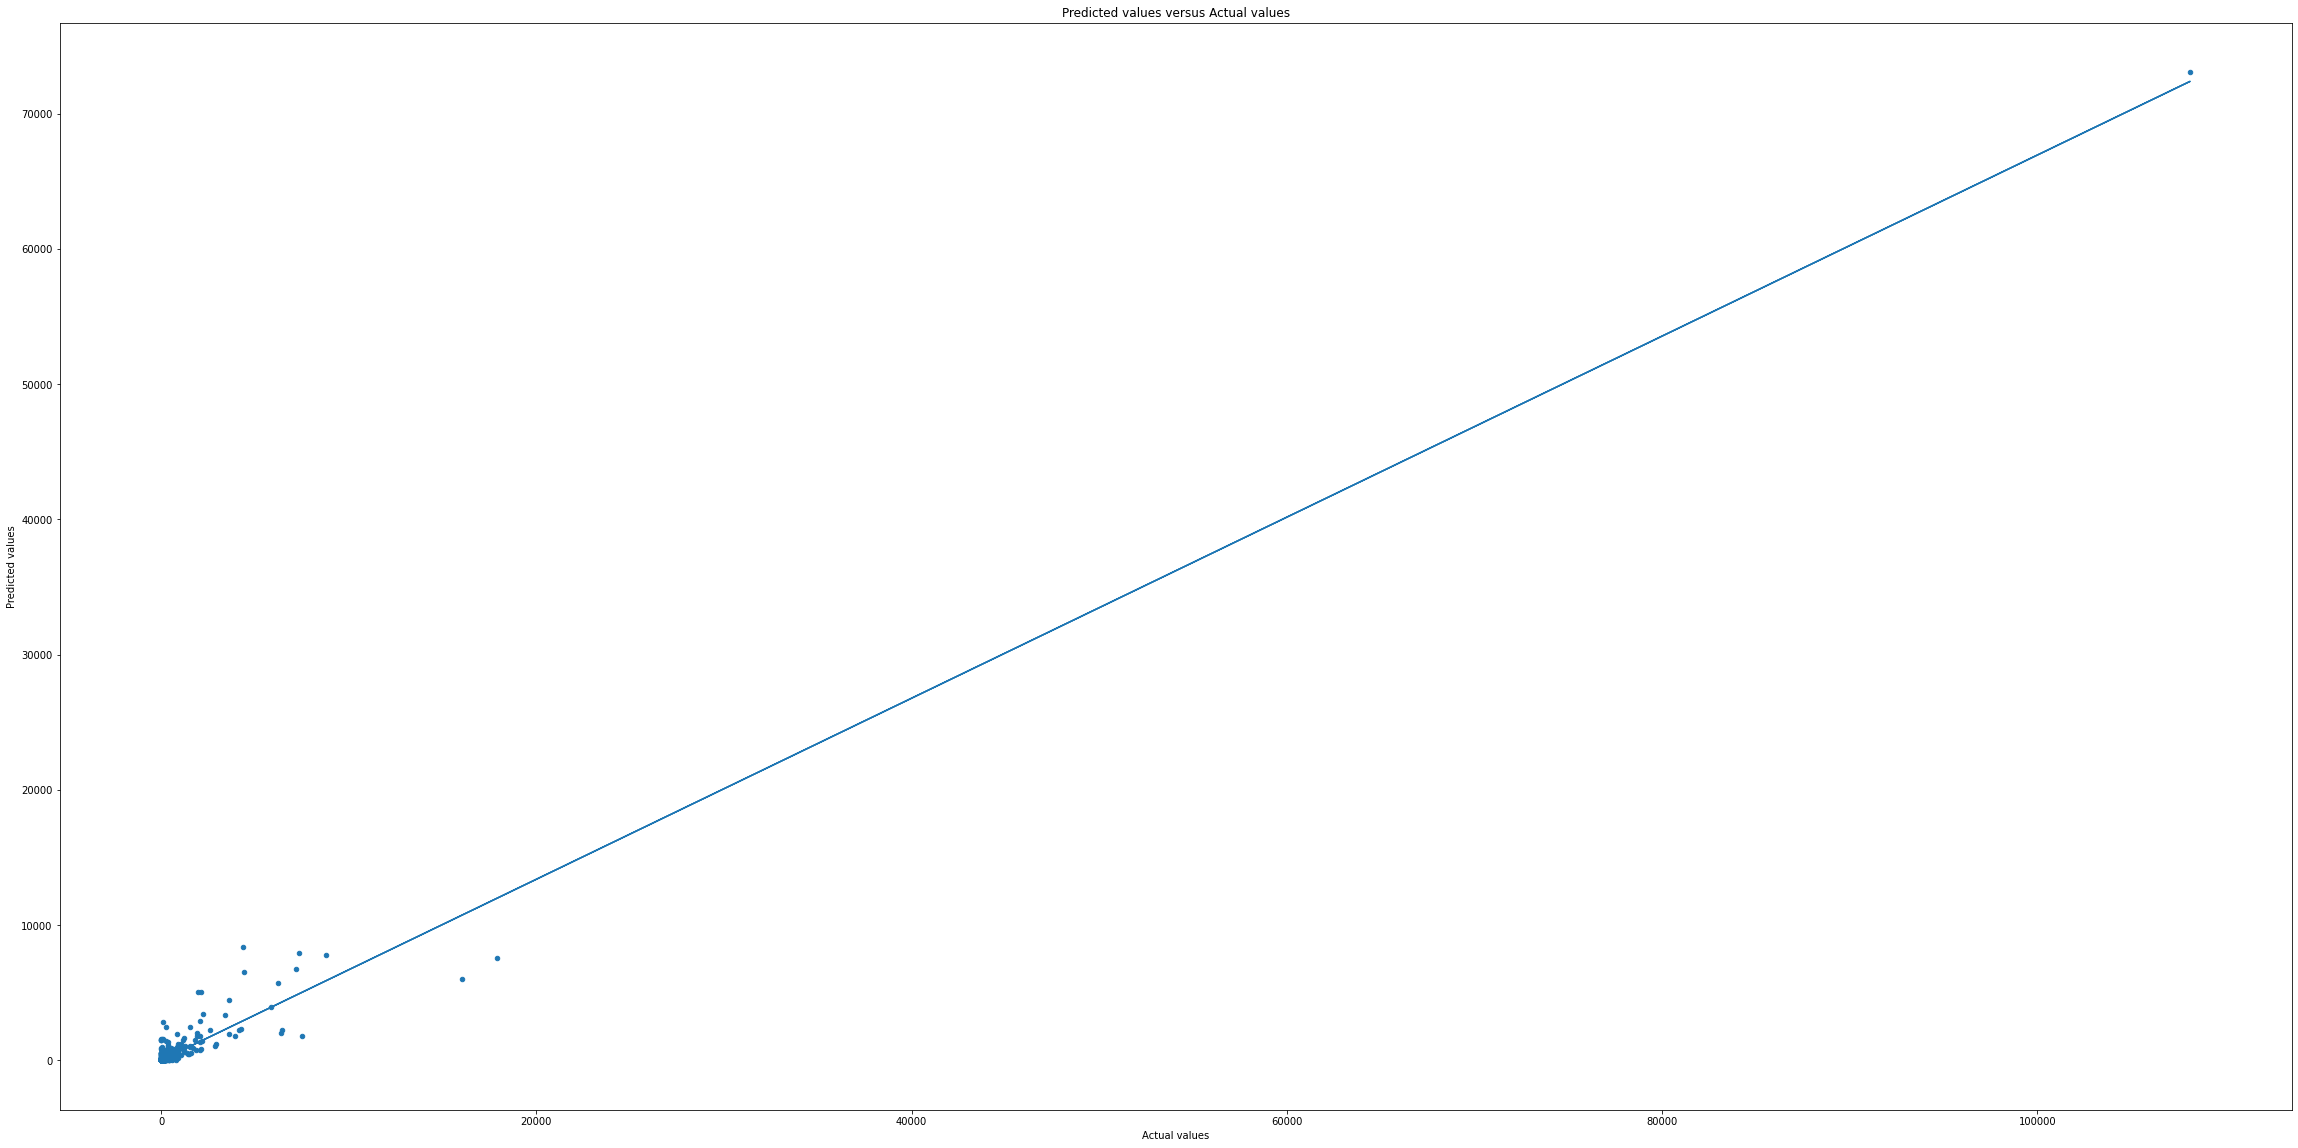

In [101]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(40,20),title="Predicted values versus Actual values")
plot_1.set_ylabel("Predicted values")
plot_1.set_xlabel("Actual values")

b, m = polyfit(df_plot_1.actual, df_plot_1.predicted, 1)
plot_1.plot(df_plot_1.actual, b + m * df_plot_1.actual, '-')



Removing outliers covering only 99.7%

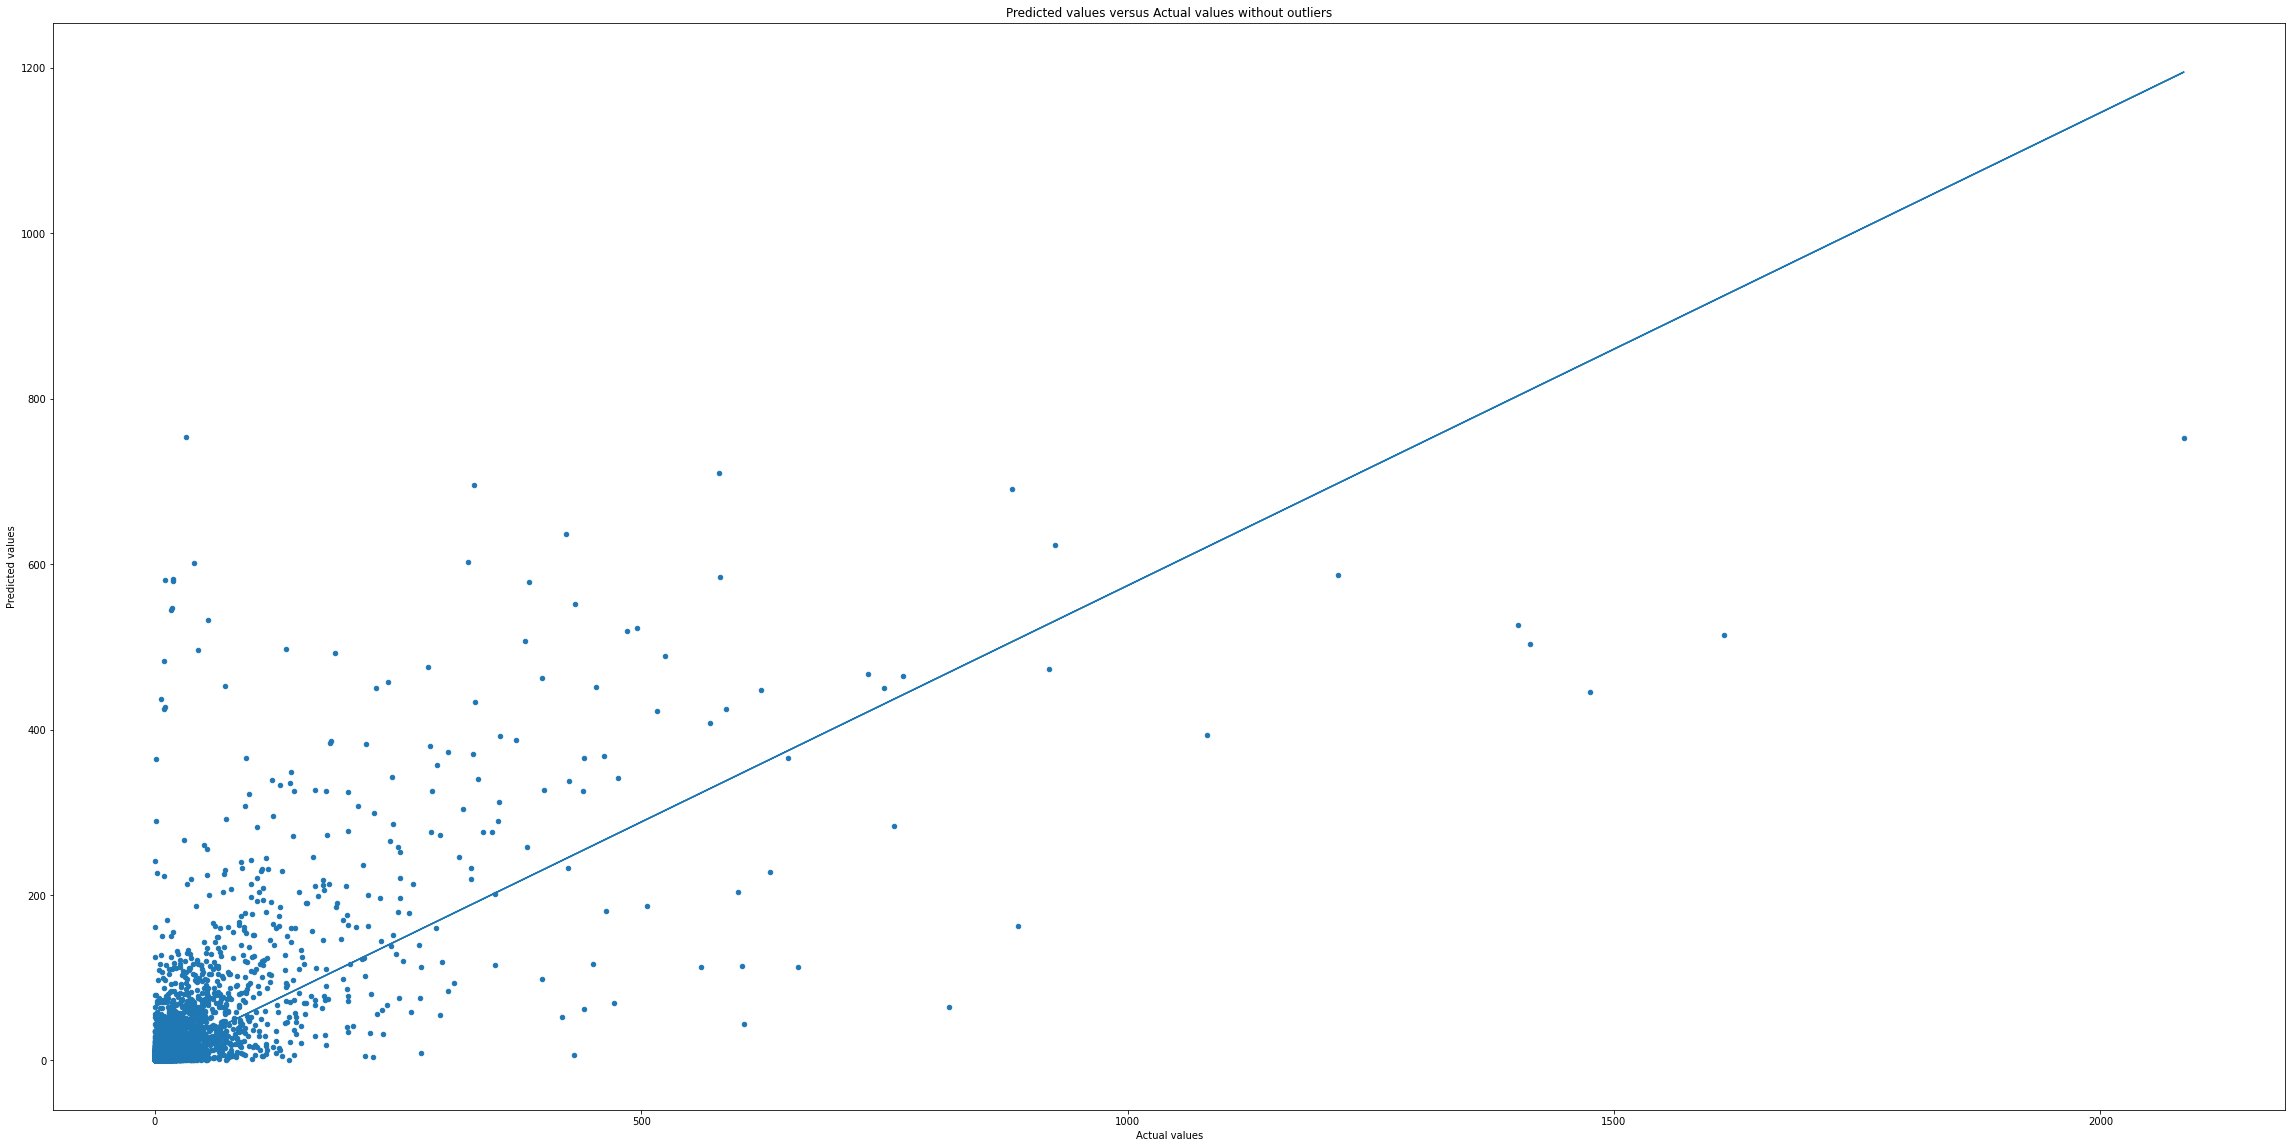

In [102]:
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(.0015), df_plot_1.predicted.quantile(0.9985))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(40,20),title="Predicted values versus Actual values without outliers")
plot_2.set_ylabel("Predicted values")
plot_2.set_xlabel("Actual values")

b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

In [97]:
print(len(df_plot_1))
print(len(df_plot_2))

49078
48934


# Further Attempts

- Groupby user_screen_name
- calculate the mean sentiment score
- see whether there are any correlation between number of followers and number of favourite tweets against the mean sentimental score (check SD)

explain properly an understanding of why introducing new feature

In [53]:
dfOriginals.groupby('user_screen_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

,user_screen_name,counts
27508,ELister_social,666
79905,SattarSarki1,382
133777,iHeartFun1,185
27433,EG24NEWS,181
142347,kailashscienti1,179
...,...,...
68494,Patterico,1
68495,PattheOldBat,1
68496,PattiClifford10,1
68498,PattiMurin,1
